# Example with high-resolution CMIP6 models (~100 km) using Pangeo catalog 

### Time period

We will use data from 1985 to 2014.

### Variables 

| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
|  prsn         |    Snowfall Flux                        | [kg m-2 s-1]  | surface |
| clw           |    Mass Fraction of Cloud Liquid Water  |  [kg kg-1]    |    ml   |
| cli           |    Mass Fraction of Cloud Ice           | [kg kg-1]     |    ml   |
| tas           |    Near-Surface Air Temperature         |   [K]         | surface |
| ta            |    Air Temperature                      |  [K]          |    ml   |


## Import python packages

In [50]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xesmf as xe
%matplotlib inline

### Open CMIP6 online catalog

In [51]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,650
table_id,37
variable_id,709
grid_label,10
zstore,512171
dcpp_init_year,60


### Search correspnding data

In [52]:
list_models = ['AWI-CM-1-1-MR',
               'BCC-CSM2-MR',
               'CAMS-CSM1-0',
               'CAS-ESM2-0',
               'CESM2',
               'CESM2-WACCM-FV2',
               'CMCC-CM2-HR4',
               'CMCC-CM2-SR5',
               'CMCC-ESM2',
               'E3SM-1-0',
               'E3SM-1-1',
               'E3SM-1-1-ECA',
               'EC-Earth3',
               'EC-Earth3-AerChem',
               'EC-Earth3-CC',
               'EC-Earth3-Veg',
               'FGOALS-f3-L',
               'FIO-ESM-2-0',
               'GFDL-CM4',
               'GFDL-ESM4',
               'HadGEM3-GC31-MM',
               'INM-CM4-8',
               'INM-CM5-0',
               'MPI-ESM1-2-HR',
               'MRI-ESM2-0',
               'NorESM2-MM',
               'SAM0-UNICON',
               'TaiESM1', 
               ]



In [53]:
variable_id=['prsn']
cat = col.search(source_id=list_models, experiment_id=['historical'], variable_id=variable_id[0], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,day,prsn,gr2,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
1,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,day,prsn,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
2,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,3hr,prsn,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
3,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,3hr,prsn,gr2,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
4,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,prsn,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
5,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Amon,prsn,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
6,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,day,prsn,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181127
7,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Omon,prsn,gn,gs://cmip6/CMIP6/CMIP/AWI/AWI-CM-1-1-MR/histor...,NaN,20181218
8,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Amon,prsn,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190222
9,CMIP,SNU,SAM0-UNICON,historical,r1i1p1f1,day,prsn,gn,gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historic...,NaN,20190323


In [54]:
cat.df['source_id'].unique()

array(['GFDL-CM4', 'BCC-CSM2-MR', 'AWI-CM-1-1-MR', 'MRI-ESM2-0',
       'SAM0-UNICON', 'INM-CM4-8', 'EC-Earth3-Veg', 'INM-CM5-0',
       'MPI-ESM1-2-HR', 'GFDL-ESM4', 'E3SM-1-0', 'EC-Earth3',
       'NorESM2-MM', 'CESM2-WACCM-FV2', 'E3SM-1-1', 'CESM2',
       'E3SM-1-1-ECA', 'TaiESM1', 'CAS-ESM2-0', 'CMCC-CM2-SR5',
       'EC-Earth3-AerChem', 'CMCC-CM2-HR4', 'FIO-ESM-2-0', 'EC-Earth3-CC',
       'CMCC-ESM2'], dtype=object)

### Create dictionary from the list of datasets we found

- This step may take several minutes so be patient!

In [55]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [56]:
list(dset_dict.keys())

['CMIP.NCC.NorESM2-MM.historical.Amon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn',
 'CMIP.NCAR.CESM2.historical.Amon.gn',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1',
 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.Amon.gr',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.day.gr1',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.day.gn',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr2',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.day.gr2',
 'CMIP.INM.INM-CM5-0.historical.day.gr1',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.day.gr1',
 'CMIP.INM.INM-CM4-8.historical.Amon.gr1',
 'CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Amon.gr',
 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.day.gr',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.3hr.gr1',
 'CMIP.BCC.BCC-CSM2-MR.historical.day.gn',
 'CMIP.CMCC.CMCC-ESM2.historical.day.gn',
 'CMIP.INM.INM-CM4-8.historical.day.gr1',
 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.day.gr',
 'CMIP.EC-E

### Use data as xarray to make a simple plot

In [57]:
ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn']
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 192, lon: 288, member_id: 1, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    prsn       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 288, 192, 288), meta=np.ndarray>
Attributes: (12/52)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1200-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     438000.0
    ...                        ...
    title:                     NorESM2-MM output prepared for CMIP6
    tracking_id:               hdl:21.14100/554fb9db-fdc0-425c-ac68-146cba77f...
    variable_id:               prsn
    variant_label:             r1i1p1f1
    intake_esm_varname:        ['prsn']
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-MM.historical.Amon.gn

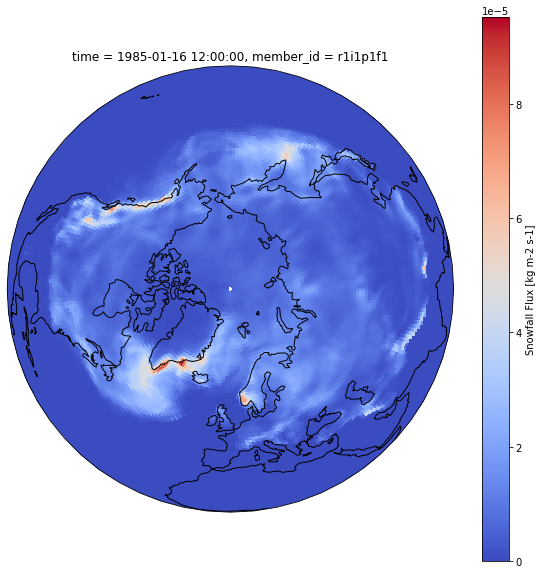

In [58]:
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()
ds['prsn'].sel(time=cftime.DatetimeNoLeap(1985, 1, 16, 12, 0, 0, 0)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

### Get attributes (unique identifier)

In [59]:
ds.attrs['tracking_id']

'hdl:21.14100/554fb9db-fdc0-425c-ac68-146cba77f8cb\nhdl:21.14100/7235eb45-2da1-4bb8-bd16-467256066116\nhdl:21.14100/f2188a57-eff0-4ab9-8263-a6654349ee18\nhdl:21.14100/3fdefb99-9db8-44c1-9a51-885f6db62cfa\nhdl:21.14100/f50ff646-df59-4eac-8080-e5da16e5d778\nhdl:21.14100/2fde10fe-1e37-4a93-ac9c-a34b8de5a606\nhdl:21.14100/25d85a61-ac30-49cd-985b-66d121e4d388\nhdl:21.14100/a83c191a-d59b-4079-87f3-8caa874fce06\nhdl:21.14100/23263a30-65b9-4887-b46c-253af00861e6\nhdl:21.14100/cbea6d5b-68dd-4db8-9500-8e2d1bcf11be\nhdl:21.14100/457e8153-b9e8-4e0a-a339-4b0f37c2992d\nhdl:21.14100/28e89d10-aa46-4629-9f96-07eb18d42bcc\nhdl:21.14100/4fe3cdb8-8434-497d-88b3-9eff0eab6264\nhdl:21.14100/4b34d44c-c673-419e-b5bb-cd01c5f382d6\nhdl:21.14100/20b0215a-3e8e-474b-9513-a80f45805ad2\nhdl:21.14100/e484b416-c59c-4ac2-bd9a-9ba2a3047d6a\nhdl:21.14100/befe4a85-4c28-4df7-9efe-0232a75ad2bc'